# Rock ou sertanejo? Machine Learning para músicas do Spotify

Este notebook apresenta a construção de um modelo classificador sobre um conjunto de músicas extraídas do Spotify.

O objetivo do classificador é identificar se uma certa música é do gênero **rock ou sertanejo**. 

Portanto, um problema de classificação binária.


## Carregando o dataset

In [0]:
import pandas as pd

In [125]:
df = pd.read_csv('tracks.csv')
print('Total tracks:', len(df))
df.head(3)

Total tracks: 785


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,name,genres,genre
0,0.695,0.775,11,-5.041,0,0.0887,0.0117,0.19100,0.0702,0.869,180.054,audio_features,05rJdH2MRLJ3sQoEUO78qs,spotify:track:05rJdH2MRLJ3sQoEUO78qs,https://api.spotify.com/v1/tracks/05rJdH2MRLJ3...,https://api.spotify.com/v1/audio-analysis/05rJ...,141317,4,Paradinha,"['baile pop', 'funk carioca', 'funk das antigas']",baile pop
1,0.778,0.826,1,-2.798,0,0.2120,0.2060,0.00000,0.7610,0.759,139.042,audio_features,2DAGCHu5aoo2FOjmtU9ojo,spotify:track:2DAGCHu5aoo2FOjmtU9ojo,https://api.spotify.com/v1/tracks/2DAGCHu5aoo2...,https://api.spotify.com/v1/audio-analysis/2DAG...,207104,4,50 Reais,"['sertanejo pop', 'funk carioca', 'sertanejo u...",sertanejo pop
2,0.699,0.739,1,-6.198,0,0.0513,0.6000,0.00361,0.3890,0.764,92.989,audio_features,40bK2uosUmAS92c17n98xd,spotify:track:40bK2uosUmAS92c17n98xd,https://api.spotify.com/v1/tracks/40bK2uosUmAS...,https://api.spotify.com/v1/audio-analysis/40bK...,218467,4,Acordando o Prédio,"['sertanejo universitario', 'funk carioca']",sertanejo universitario


## Entendendo o problema: o que queremos prever?

Analisando a distribuição dos gêneros na base de dados

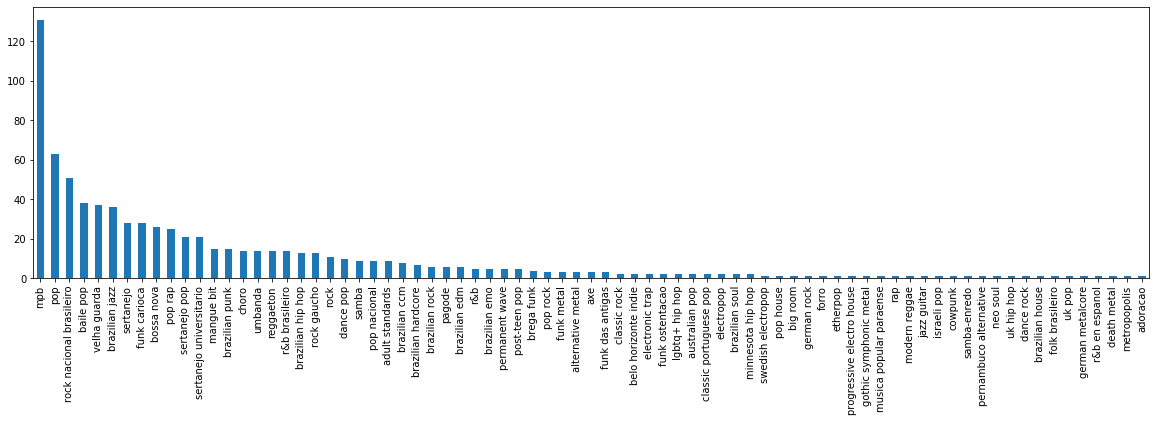

In [126]:
df['genre'].value_counts().plot(kind='bar', figsize=(20,5))

Normalizando alguns gêneros mais conhecidos

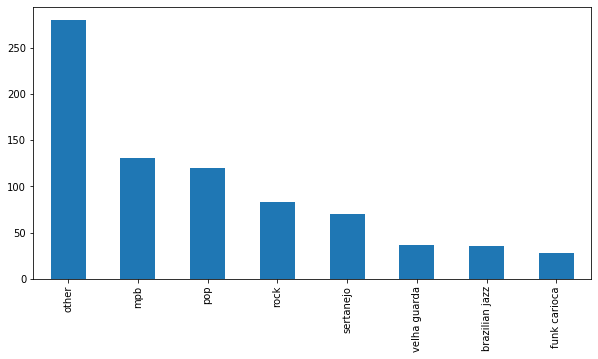

In [127]:
# defining labels (genres set)
df['genre_label'] = df['genre']
df.loc[df.genre == 'sertanejo universitario', 'genre_label'] = 'sertanejo'
df.loc[df.genre == 'sertanejo pop', 'genre_label'] = 'sertanejo'
df.loc[df.genre == 'rock nacional brasileiro', 'genre_label'] = 'rock'
df.loc[df.genre == 'rock gaucho', 'genre_label'] = 'rock'
df.loc[df.genre == 'brazilian rock', 'genre_label'] = 'rock'
df.loc[df.genre == 'classic rock', 'genre_label'] = 'rock'
df.loc[df.genre == 'pop nacional', 'genre_label'] = 'pop'
df.loc[df.genre == 'dance pop', 'genre_label'] = 'pop' 
df.loc[df.genre == 'baile pop', 'genre_label'] = 'pop' 

genres_list = ['sertanejo', 'rock', 'mpb', 'pop', 'velha guarda', 'brazilian jazz', 'funk carioca']
df['genre_label'] = df['genre_label'].apply(lambda x: x if x in genres_list else 'other')

df['genre_label'].value_counts().plot(kind='bar', figsize=(10,5))

## Classificação binária: rock ou sertanejo?

#### Limpeza e pré-processamento da base de dados

* Limpeza da base para eliminar músicas que não tenham todos os valores preenchidos
* Filtro da base para obtenção apenas de músicas de rock e sertanejo

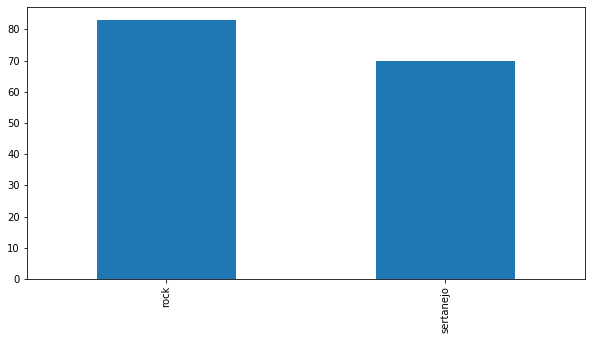

In [128]:
## preparing dataset
df_binary = df.loc[df['genre_label'].isin(['rock', 'sertanejo'])]
df_binary = df_binary.dropna()
df_binary['genre_label'].value_counts().plot(kind='bar', figsize=(10,5))

### Engenharia de Features

* observar as features existentes
* quais features fazem sentido para o problema?
* existem features diretamente correlacionadas, de modo que uma delas pode ser eliminada?
* existe uma diferença clara (visual) entre valores de rock e sertanejo para alguma feature?

In [129]:
df_binary.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,name,genres,genre,genre_label
1,0.778,0.826,1,-2.798,0,0.2120,0.206,0.00000,0.761,0.759,139.042,audio_features,2DAGCHu5aoo2FOjmtU9ojo,spotify:track:2DAGCHu5aoo2FOjmtU9ojo,https://api.spotify.com/v1/tracks/2DAGCHu5aoo2...,https://api.spotify.com/v1/audio-analysis/2DAG...,207104,4,50 Reais,"['sertanejo pop', 'funk carioca', 'sertanejo u...",sertanejo pop,sertanejo
2,0.699,0.739,1,-6.198,0,0.0513,0.600,0.00361,0.389,0.764,92.989,audio_features,40bK2uosUmAS92c17n98xd,spotify:track:40bK2uosUmAS92c17n98xd,https://api.spotify.com/v1/tracks/40bK2uosUmAS...,https://api.spotify.com/v1/audio-analysis/40bK...,218467,4,Acordando o Prédio,"['sertanejo universitario', 'funk carioca']",sertanejo universitario,sertanejo


In [130]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence']
features_selection = ['name', 'genre_label'] + features
df_binary = df_binary[features_selection]
df_binary.tail(5)

,name,genre_label,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
775,O Tempo Não Pára,rock,0.358,0.766,-9.715,0.0603,0.034300,0.000000,0.9830,0.362
778,A feira,rock,0.713,0.886,-7.750,0.0412,0.001200,0.000007,0.0496,0.900
779,Até Quando Esperar,rock,0.521,0.787,-9.691,0.0364,0.000147,0.002140,0.2580,0.651
780,Eu quero ver o oco,rock,0.669,0.960,-6.432,0.0606,0.002310,0.000000,0.1040,0.580
782,1406,rock,0.746,0.665,-10.154,0.1330,0.034700,0.000000,0.0806,0.777


Analisando correlações entre features


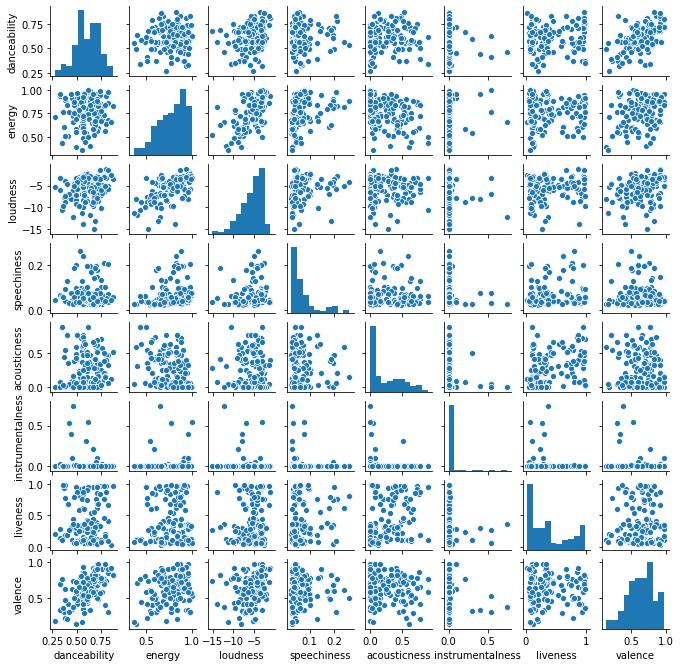

In [131]:
from matplotlib import pyplot
import seaborn as sns

ax = sns.pairplot(df_binary)
ax.fig.set_size_inches(9,9)

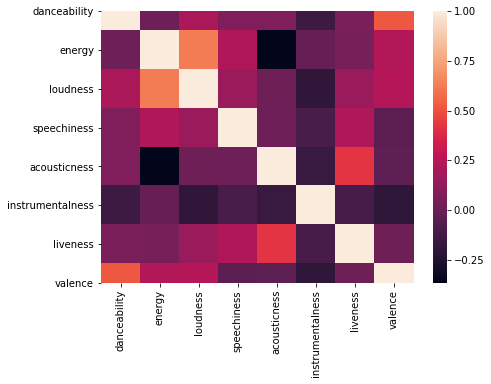

In [132]:
corr = df_binary[features].corr()

# plotting
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 7
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
ax = sns.heatmap(corr)

Analisando especificidades de cada gênero

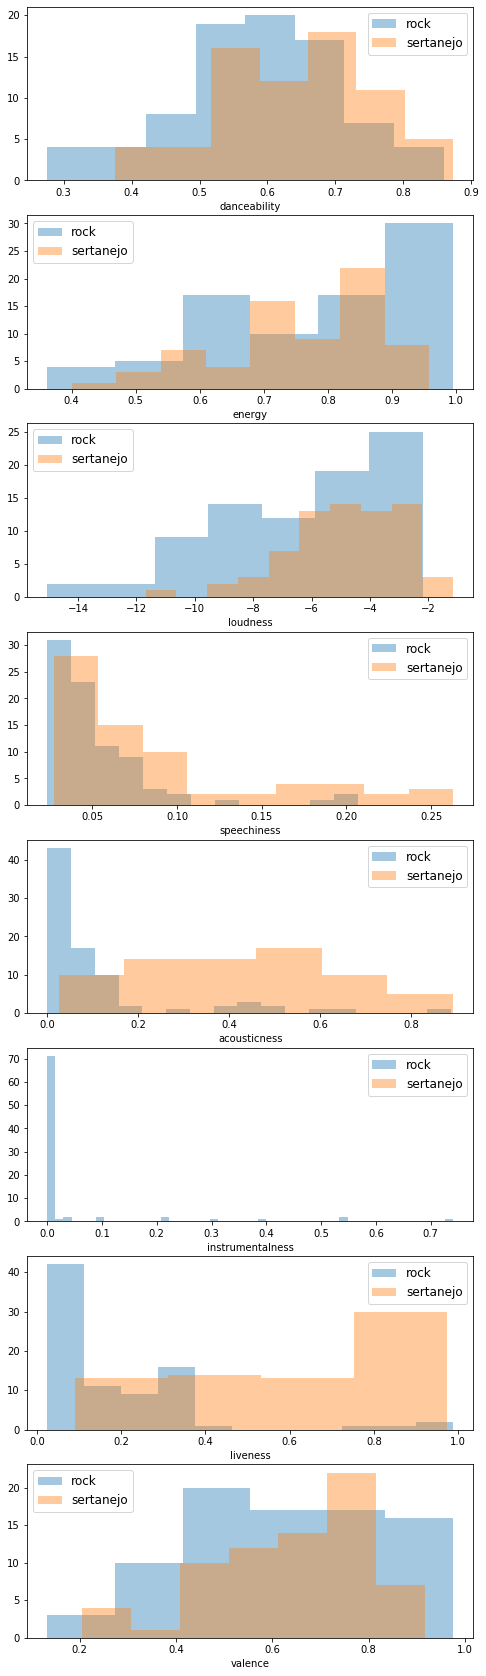

In [133]:
# Plot formatting
import matplotlib.pyplot as plt
fig, axs = plt.subplots(8)
for i in range(8):
  df = df_binary[df_binary.genre_label == 'rock']
  sns.distplot(df[features[i]],  kde=False, label='rock', ax=axs[i])

  df = df_binary[df_binary.genre_label == 'sertanejo']
  sns.distplot(df[features[i]],  kde=False, label='sertanejo', ax=axs[i])

  axs[i].legend(prop={'size': 12})
fig.set_size_inches(8,30)

### Construindo um classificador

* classificador é um modelo matemático, treinado a partir de um conjunto de dados, capaz de atribuir classes (labels/rótulos) a uma instância inédita, com uma certa qualidade
* uma classificador binário é capaz de decidir entre 2 classes (rock ou sertanejo)
* a construção de um classificador envolve o desenvolvimento (escolha, tunning, treinamento) do melhor modelo matemático para o problema em questão 

#### Divisão entre instâncias de treino e instâncias de teste
* Quais músicas vou usar pra treinar o modelo?
* Quais músicas vou separar para avaliar a qualidade do modelo que treinei?

In [0]:
# train test split
X = df_binary[features]
y = df_binary['genre_label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Treinamento e Avaliação

* Para treinar: .fit()
* Para avaliar existem medidas: precision, recall, accuracy, F1, ...

In [135]:
# training
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train, y_train)

# predicting
y_predicted = clf.predict(X_test)

# model evaluation
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_predicted))
print('Accuracy:', accuracy_score(y_test, y_predicted))

              precision    recall  f1-score   support

        rock       1.00      0.32      0.48        22
   sertanejo       0.53      1.00      0.69        17

    accuracy                           0.62        39
   macro avg       0.77      0.66      0.59        39
weighted avg       0.80      0.62      0.57        39

Accuracy: 0.6153846153846154


In [136]:
# training
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)

# predicting
y_predicted = clf.predict(X_test)

# model evaluation
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_predicted))
print('Accuracy:', accuracy_score(y_test, y_predicted))

              precision    recall  f1-score   support

        rock       0.95      0.86      0.90        22
   sertanejo       0.84      0.94      0.89        17

    accuracy                           0.90        39
   macro avg       0.90      0.90      0.90        39
weighted avg       0.90      0.90      0.90        39

Accuracy: 0.8974358974358975


#### Construindo um classificador robusto

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [0]:
# models
LSVC = LinearSVC(max_iter=20000)
RFO = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
KNN = KNeighborsClassifier(n_neighbors=7)
GNB = GaussianNB()
VOTING = VotingClassifier(estimators=[('LSVC', LSVC), ('RFO', RFO), ('GNB', GNB)], voting='hard', weights=[5,4,3])
EXTRATREES = ExtraTreesClassifier(n_estimators=200, max_depth=None,min_samples_split=3, random_state=0)
BAGGING = BaggingClassifier(base_estimator=GNB)
ADABOOST = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None), algorithm="SAMME", n_estimators=600)
GRDBOOSTING = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0,max_depth=5, random_state=0)

In [139]:
models = [
    LSVC,
    RFO,
    MLP,
    KNN,
    GNB,
    VOTING,
    EXTRATREES,
    BAGGING,
    ADABOOST,
    GRDBOOSTING
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * (len(models)+1)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

LinearSVC
RandomForestClassifier
MLPClassifier
KNeighborsClassifier
GaussianNB
VotingClassifier
ExtraTreesClassifier
BaggingClassifier
AdaBoostClassifier
GradientBoostingClassifier


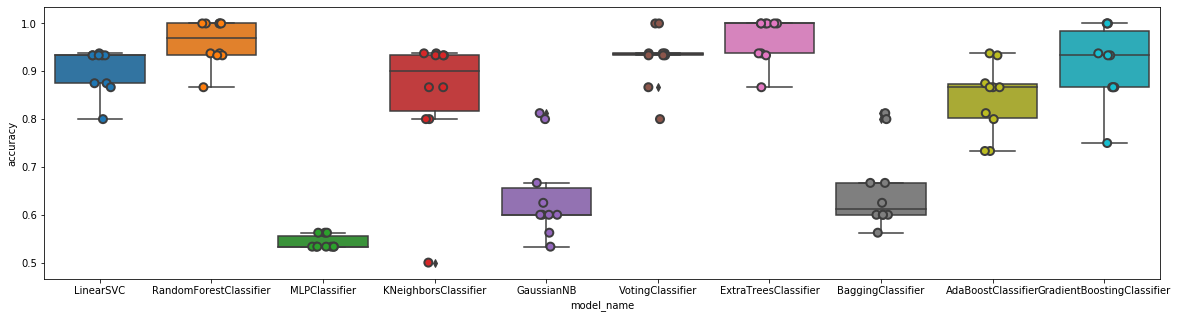

In [140]:
import seaborn as sns
from matplotlib.pyplot import figure
%matplotlib inline

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
    
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [141]:
cv_df.groupby('model_name').mean()

,fold_idx,accuracy
model_name,,
AdaBoostClassifier,4.5,0.842500
BaggingClassifier,4.5,0.653333
ExtraTreesClassifier,4.5,0.967500
GaussianNB,4.5,0.640000
GradientBoostingClassifier,4.5,0.915417
KNeighborsClassifier,4.5,0.850833
LinearSVC,4.5,0.902083
MLPClassifier,4.5,0.542083
RandomForestClassifier,4.5,0.960833


In [0]:
# Classificador escolhido: Random Forest (RFO)
model = RFO.fit(X, y)

#### Salvando o classificador construído

In [143]:
# Salvando o modelo
from sklearn.externals import joblib
import pickle

joblib.dump(model, 'genre-rock-sertanejo-model.joblib') 

model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## E agora? O que fazer com um classificador?

In [0]:
...